In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class DoubleConv(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c,out_c,(3,3),padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,(3,3),padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv(x)

    
class DownConv(nn.Module):
    def __init__(self,in_c, out_c):
        super().__init__()
        self.conv = DoubleConv(in_c,out_c)
        self.pool =  nn.MaxPool2d((2,2),stride=2)
    
    def forward(self,x):
        skip_conn = self.conv(x)
        return skip_conn, self.pool(skip_conn)

class UpConv(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.up = nn.ConvTranspose2d(in_c,out_c,(2,2),stride=2)
        self.conv = DoubleConv(in_c,out_c)
    
    def forward(self,x1,x2):
        x2 = self.up(x2)
        x = torch.cat([x1,x2],dim=1)
        return self.conv(x)

In [5]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.down1 = DownConv(3,64)
        self.down2 = DownConv(64,128)
        self.down3 = DownConv(128,256)
        self.down4 = DownConv(256,512)
        
        self.bottle = DoubleConv(512,1024)
        
        self.up1 = UpConv(1024,512)
        self.up2 = UpConv(512,256)
        self.up3 = UpConv(256,128)
        self.up4 = UpConv(128,64)
        
        self.final = nn.Conv2d(64,1,(1,1))

    def forward(self,x):
        
        s1,x = self.down1(x)
        s2,x = self.down2(x)
        s3,x = self.down3(x)
        s4,x = self.down4(x)
        
        x = self.bottle(x)
        
        x = self.up1(s4,x)
        x = self.up2(s3,x)
        x = self.up3(s2,x)
        x = self.up4(s1,x)
        
        return self.final(x)
    

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [10]:
# def binary_tversky_loss(target, pred,
#                         alpha=0.3,
#                         beta=0.7,
#                         smooth=1):
#     batch_size = pred.shape[0]

#     pred = torch.sigmoid(pred).view(batch_size, -1)
#     target = target.view(batch_size, -1)

#     TP = torch.sum(pred * target, dim=1)
#     FP = torch.sum(pred * (1 - target), dim=1)
#     FN = torch.sum((1 - pred) * target, dim=1)
#     tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)

#     result = 1 - tversky
#     return torch.mean(result)

In [8]:
import os
import cv2
from torchvision.io import read_image
from torchvision.transforms import ToTensor

def load_dataset(dir_path):
    orig = []
    mask = []
    
    orig_path = f'{dir_path}/Original'
    mask_path = f'{dir_path}/Ground truth'
    
    img_names = os.listdir(orig_path)
    
    for name in img_names:
        if '.png' not in name:
            continue
        orig_img = cv2.resize(cv2.imread(f'{orig_path}/{name}',cv2.IMREAD_COLOR),(512,512))
        mask_img = cv2.resize(cv2.imread(f'{mask_path}/{name}',cv2.IMREAD_GRAYSCALE),(512,512))
        orig_tensor = ToTensor()(orig_img)
        mask_tensor = ToTensor()(mask_img)
        orig.append(orig_tensor)
        mask.append(mask_tensor)
    
    return orig, mask


In [9]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, dir_path,is_train):
        folder = '/train' if is_train else '/test'
        X,y = load_dataset(dir_path+folder)
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]

dir_path = '/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation'
train_dataset = MyDataset(dir_path,True)
test_dataset = MyDataset(dir_path, False)  

len(train_dataset), len(test_dataset)

(600, 200)

In [10]:
from sklearn.model_selection import train_test_split

test_dataset, valid_dataset = train_test_split(test_dataset,test_size=0.5,random_state=42)

len(test_dataset), len(valid_dataset) 

(100, 100)

In [14]:
test_dataset[0][1].shape

torch.Size([1, 256, 256])

In [11]:
train_dataloader = DataLoader(train_dataset,batch_size=8)
test_dataloader = DataLoader(test_dataset,batch_size=8)
valid_dataloader = DataLoader(valid_dataset,batch_size=8)

In [12]:
model = Unet()
model.to(device)
optim = torch.optim.SGD(model.parameters(),lr = 5e-4,momentum=0.99)
#optim = torch.optim.Adam(model.parameters(),lr=5e-4)
criterion = DiceBCELoss().to(device)
epochs = 50
loss_values = []
vloss_values = []
min_loss = 10000
for epoch in range(epochs):
    print(f'epochs:{epoch}')
    running_loss = 0.0
    model.train(True)
    for i,data in enumerate(train_dataloader):
        img, mask = data
        img = img.to(device)
        mask = mask.to(device)
        out = model(img)
        
        loss = criterion(out,mask)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
    
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader):
            img, mask = data
            img = img.to(device)
            mask = mask.to(device)
            out = model(img)
            loss = criterion(out,mask)
            running_vloss += loss.item()       
    
    loss_values.append(running_loss/len(train_dataset))
    vloss_values.append(running_vloss/len(valid_dataset))
    print(f'train and valid loss after epoch: {loss_values[-1]:.5f}, {vloss_values[-1]:.5f}')
    
    if min_loss > vloss_values[-1]:
        min_loss = vloss_values[-1]
        torch.save(model.state_dict(), 'model.pth')
        print('model saved')

epochs:0
train and valid loss after epoch: 0.18703, 0.17917
model saved
epochs:1
train and valid loss after epoch: 0.15829, 0.15453
model saved
epochs:2
train and valid loss after epoch: 0.15017, 0.15507
epochs:3
train and valid loss after epoch: 0.14858, 0.15290
model saved
epochs:4
train and valid loss after epoch: 0.14776, 0.15295
epochs:5
train and valid loss after epoch: 0.14774, 0.15292
epochs:6
train and valid loss after epoch: 0.14762, 0.15270
model saved
epochs:7
train and valid loss after epoch: 0.14732, 0.15226
model saved
epochs:8
train and valid loss after epoch: 0.14677, 0.15145
model saved
epochs:9
train and valid loss after epoch: 0.14577, 0.15014
model saved
epochs:10
train and valid loss after epoch: 0.14430, 0.14854
model saved
epochs:11
train and valid loss after epoch: 0.14279, 0.14723
model saved
epochs:12
train and valid loss after epoch: 0.14188, 0.14674
model saved
epochs:13
train and valid loss after epoch: 0.14166, 0.14666
model saved
epochs:14
train and vali

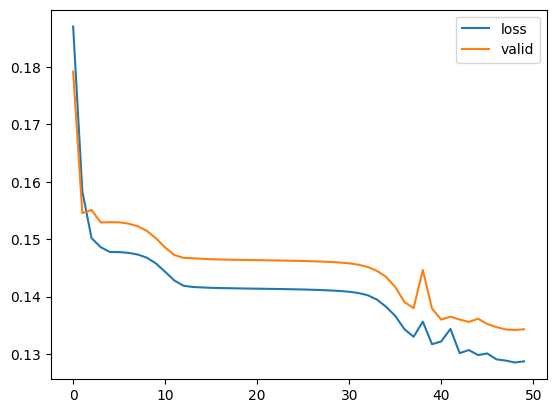

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_values,label='loss')
plt.plot(vloss_values,label = 'valid')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [14]:
model = Unet()
model.load_state_dict(torch.load('/kaggle/input/unet/pytorch/default/1/model.pth'))
model.to(device)
model.eval()

Unet(
  (down1): DownConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
  

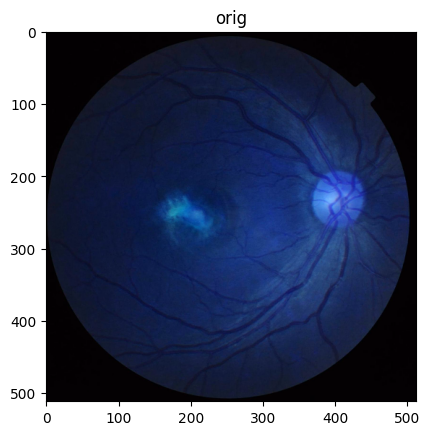

torch.Size([512, 512, 1])


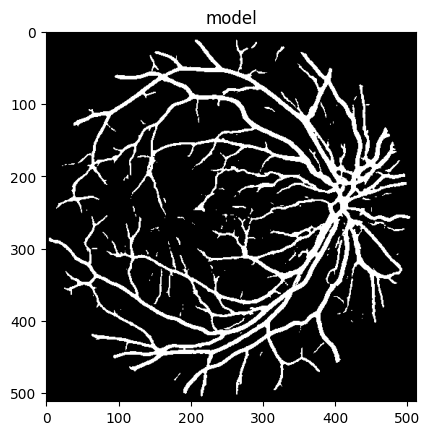

torch.Size([512, 512, 1])


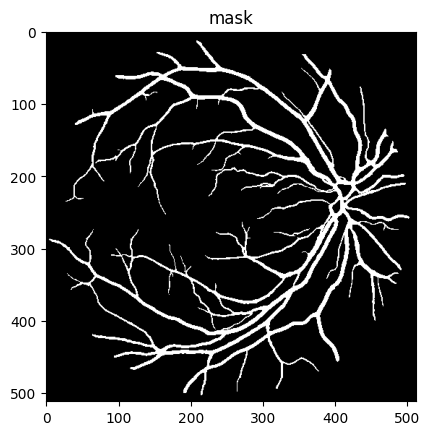

In [68]:
import cv2
import numpy as np
import torchvision.transforms as transforms

def postporcessing(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    norm_tensor = (tensor - min_val) / (max_val - min_val)
    bin_tensor = (norm_tensor >= 0.5).float()
    return bin_tensor

for i,data in enumerate(test_dataloader):
    img, mask = data
    for item in img:
        plt.imshow(item.permute(1,2,0))
        plt.title('orig')
        plt.show()
        item = item.unsqueeze(0)
        item = item.to(device)
        out = model(item)
        img = out[0].cpu().detach().permute(1,2,0)
        print(img.shape)
        img = postporcessing(img)
        plt.imshow(img,cmap='gray')
        plt.title('model')
        plt.show()
        break
    for item in mask:
        item = item.to(device)
        img = ToPILImage()(item)
        img = item.cpu().detach().permute(1,2,0)
        print(img.shape)
        img = postporcessing(img)
        plt.imshow(img,cmap='gray')
        plt.title('mask')
        plt.show()
        break
    break

In [ ]:
path = '/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/100_A.png'
img = cv2.imread(path,cv2.IMREAD_COLOR)
img.shape, np.unique(img)

In [ ]:
gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
gray.shape,np.unique(gray)